In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    silhouette_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    max_error,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score,cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.impute import SimpleImputer
import pickle

workspace_directory = r'C:\Users\trygg\Documents\Master_project'  # HOME
# workspace_directory = r"C:\Users\tryggvisi\Documents\my-awesome-masters-project"  # WORK
# Change the current working directory to the specified workspace
os.chdir(workspace_directory)
import sklearn

random_state = 42 # set random state for SK models

ID clean kemur frá frum vindelfjallen hreinsuðu gögnunum, þar eru umþb 500 línur með sitt ID. Þannig að hver mæling hefur sitt ID. en Við vinnslu backscatter gagna, voru sumir punktar með 2 mælingar, og því eru fleiri en einn ID_CLEAN, og það vantar líka nokkra.

Vegetation from https://www.lantmateriet.se/en/geodata/geodata-products/international-cooperation/corine-land-cover/#anchor-4


# Dataset preperations


#### The great filter


In [2]:
def cleaning_the_data(file_old, file_era5, resolution, temperature, std):
    # Step 1: Read the main CSV datafile, either old and ERA5 data or just the old data
    path_to_folder = r"Data\Vindefjallen_data\Vindefjallen_cleaning\exploratory_data_analysis\2_values_from_raster_python_R"
    if file_era5 != 'none':
        path_old = os.path.join(path_to_folder, file_old)
        df_data1 = pd.read_csv(path_old)
        df_data1["original"] = 0  # 0 for old data

        path_era5 = os.path.join(path_to_folder, file_era5)
        df_data2 = pd.read_csv(path_era5)
        df_data2["original"] = 1  # 1 for ERA5 data
        df_data = pd.concat([df_data1, df_data2], ignore_index=True)
    elif file_era5 == 'none':
        path_old = os.path.join(path_to_folder, file_old)
        df_data = pd.read_csv(path_old)
        df_data["original"] = 0

    # Step 2: Rename columns in the main data frame
    df_data.rename(columns={"ID": "ID_clean", "OG_ID": "ID_preclean", "MiddleTime": "middleTime", "SnowDepth": "snow_depth",
                            "point_VH": "VH", "point_VV": "VV", "points_angle": "angle"}, inplace=True)

    # Step 3: Read the DEM dataset and prepare it for merging
    path_file = r"Data\Vindefjallen_data\Vindefjallen_cleaning\exploratory_data_analysis\4_DEM_data\DEM_extracted_values.csv"
    df_DEM = pd.read_csv(path_file)
    df_DEM = df_DEM.drop(["FID", "OG_ID", "Triangle", "Corner", "TriangleCo", "date", "SnowDepth", "SnowDepth_",
                          "temperatur", "x_4326", "y_4326", "x_3006", "y_3006", "MiddleTime"], axis=1)

    # Step 4: Read the ERA5 dataset
    # with 3 parameters and complete list.THIS IS OLD AND BAR ERA5
    path_data_era = r"Scripts\Python\ERA5\era5_temp\era5_vindefjallen_data_2023_3params_new.csv"
    df_read_era = pd.read_csv(path_data_era)

    # read the era5-land dataset
    # path_data_era_land = r"Scripts\Python\ERA5\era5_temp\era5_land_vindefjallen_data_2023_4params.csv" #með skt,sde,sd,rsn
    path_data_era_land = r"Scripts\Python\ERA5\era5_temp\era5_land_vindefjallen_data_2023_7params.csv"  # með skt,sde,sd + vgt h og l og snow temp
    df_read_era_land = pd.read_csv(path_data_era_land)

    # Step 5b: Read vegetation type dataset and prepare it for merging
    read_vegtyp = r"Data\Landcover\Derived_datasets\points_with_vegtyp.xls"
    df_vegtyp = pd.read_excel(read_vegtyp)
    df_vegtyp = df_vegtyp.drop_duplicates(subset=['TriangleCo'])
    df_vegtyp.reset_index(drop=True, inplace=True)
    df_vegtyp = df_vegtyp[['TriangleCo', 'VEGETATION', 'VEGTYP']]

    # Step 6: Merge with DEM dataset
    df_merge_DEM = pd.merge(left=df_data, right=df_DEM, left_on=[
                            "ID_clean"], right_on=["ID"], how="left")

    # Step 7: Merge with ERA5 dataset
    df_merge_ERA5 = pd.merge(left=df_merge_DEM, right=df_read_era, left_on=[
                             "ID_clean"], right_on=["ID"], how="left")

    df = pd.merge(left=df_merge_ERA5, right=df_read_era_land, left_on=[
                  "ID_clean"], right_on=["ID"], how="left")

    # Step 9: Convert snow depth to integer and remove rows with '+'
    df = df[~df["snow_depth"].str.contains(r"\d+\+")]
    df["snow_depth"] = df["snow_depth"].astype(np.int64)

    # Step 10: Remove rows with NaN in VH column and one outlier row
    df = df.dropna(subset=["VH"])

    # step 10.1: AC-28C because it's on a lake.
    df = df[df["TriangleCorner"] != "AC-28C"]

    # Step 11: Remove rows with geometric distortions
    df = df[df["points_mask"] == 0]

    # Step 13: Calculate VH/VV ratio
    df["VH/VV"] = df["VH"] / df["VV"]

    # Step 14: Filter data based on standard deviations
    # df = df[np.abs(df["VH/VV"] - df["VH/VV"].mean()) <= (std * df["VH/VV"].std())]
    df = df[np.abs(df["VH"] - df["VH"].mean()) <= (std * df["VH"].std())]
    df = df[np.abs(df["VV"] - df["VV"].mean()) <= (std * df["VV"].std())]

    # Step 15: One-hot encode orbitProp
    df[["orbitProp_ASCENDING", "orbitProp_DESCENDING"]
       ] = df["orbitProp"].str.get_dummies()

    # Step 16: Impute missing values in the temperature column
    if temperature == "drop":
        df = df.dropna(subset=["temperature"])
        print("Dropping rows with missing values in temperature")
    elif temperature in ["most_frequent", "mean"]:
        imp = SimpleImputer(strategy=temperature)
        df["temperature"] = imp.fit_transform(df[["temperature"]])
        print(
            f"Imputing missing values in temperature with {temperature} value")
    elif temperature == "skip":
        print("Skipping temperature imputation")
    else:
        print("No valid input for temperature imputation")

    # Step 17: Select columns to keep
    df = df[["ID_clean", "TriangleCorner", "date", "snow_depth", "time_difference",
            #  "temperature", "middleTime", "orbitProp_DESCENDING","orbitProp", 
            "VH", "VV", "VH/VV", "angle", "TPI_100",  "TRI_100","ASP_100","SLOP_100","ELEV_100",
             "TRI_500",  "ELEV_500",  "ASP_500", "SLO_500", "ASP_1000", "SLO_1000","TRI_1000", "ELEV_1000","TPI_500", "TPI_1000",
               
               "orbitProp_ASCENDING", 
             "original",
             "t2m", "rsn", "sd",
             "era5_l_rsn",  "era5_l_sd", "era5_l_skt", "era5_l_sde",
             "era5_l_lai_hv", "era5_l_lai_lv", "era5_l_tsn",
             ]]

    # Step 18: Reset index
    df.reset_index(drop=True, inplace=True)

    # Step 19: Convert time_difference to integer hours and round to nearest hour
    for i in range(len(df)):
        time_components = df.loc[i, "time_difference"].split(":")
        if len(time_components) == 3:
            hours, minutes, seconds = map(int, time_components)
        elif len(time_components) == 2:
            hours, minutes = map(int, time_components)
            seconds = 0
        else:
            raise ValueError("Invalid time string format")
        total_hours = round(hours + minutes / 60 + seconds / 3600)
        df.loc[i, "time_difference_rnd"] = total_hours

    df["snow_depth"] = df["snow_depth"].apply(lambda x: round(x, -1))

    df = df[np.abs(df["TRI_100"] - df["TRI_100"].mean())
            <= (4 * df["TRI_100"].std())]
    # converting snow depth to real snow depth

    df['resolution'] = resolution
    df['era5_l_sde'] = df['era5_l_sde'] * 100

    #filter snow depths over 50 and less than 300
    # df = df[(df['snow_depth'] > 90) & (df['snow_depth'] < 200)]
    df.reset_index(drop=True, inplace=True)

    return df

#### More functions and filters


In [3]:
data_100 = r"values_to_points_R_100.csv"
data_500 = r"values_to_points_R_500.csv"
data_1000 = r"values_to_points_R_1000.csv"
data_era5_100 = r"values_to_points_R_era5_100.csv"
data_era5_500 = r"values_to_points_R_era5_500.csv"
data_era5_1000 = r"values_to_points_R_era5_1000.csv"

temperature = "skip"
std = 3
df_100 = cleaning_the_data(data_100, data_era5_100,'100', temperature=temperature, std=std)
print(df_100.shape)
df_500 = cleaning_the_data(data_500, data_era5_500,'500', temperature=temperature, std=std)
print(df_500.shape)
df_1000 = cleaning_the_data(data_1000, data_era5_1000,'1000', temperature=temperature, std=std)
print(df_1000.shape)

Skipping temperature imputation
(475, 38)
Skipping temperature imputation
(477, 38)
Skipping temperature imputation
(485, 38)


In [4]:
print(df_1000.to_markdown())

|     |   ID_clean | TriangleCorner   | date       |   snow_depth | time_difference   |         VH |        VV |     VH/VV |   angle |     TPI_100 |   TRI_100 |    ASP_100 |   SLOP_100 |   ELEV_100 |   TRI_500 |   ELEV_500 |   ASP_500 |   SLO_500 |   ASP_1000 |   SLO_1000 |   TRI_1000 |   ELEV_1000 |    TPI_500 |   TPI_1000 |   orbitProp_ASCENDING |   original |     t2m |     rsn |          sd |   era5_l_rsn |   era5_l_sd |   era5_l_skt |   era5_l_sde |   era5_l_lai_hv |   era5_l_lai_lv |   era5_l_tsn |   time_difference_rnd |   resolution |
|----:|-----------:|:-----------------|:-----------|-------------:|:------------------|-----------:|----------:|----------:|--------:|------------:|----------:|-----------:|-----------:|-----------:|----------:|-----------:|----------:|----------:|-----------:|-----------:|-----------:|------------:|-----------:|-----------:|----------------------:|-----------:|--------:|--------:|------------:|-------------:|------------:|-------------:|----------

### Data exploration various


In [ ]:
# unique words
def unique_words(df, column_name):
    unique_words = df[column_name].unique()
    print(f"Unique words in {column_name}: {len(unique_words)}")
    print(df[column_name].value_counts().to_markdown())
    return df[column_name].value_counts()
unique_words(df_1000, 'ID_clean')

In [56]:
df = df_100
num_columns = [
    "VH",
    "VV",
    "VH/VV",
    "angle",
    "time_difference_rnd",
    'orbitProp_ASCENDING',
    "ELEV_100",
    "ASP_100",
    "SLOP_100",
    "TPI_100",
    "TRI_100",
    "t2m",
    "rsn",
    "snow_depth"]

pd.DataFrame(data=[df[num_columns].skew(), df[num_columns].kurtosis()], index=[
             'skewness', 'kurtosis'])

,VH,VV,VH/VV,angle,time_difference_rnd,orbitProp_ASCENDING,ELEV_100,ASP_100,SLOP_100,TPI_100,TRI_100,t2m,rsn,snow_depth
skewness,1.216806,0.99287,0.520520,0.264407,0.837966,0.097263,1.09649,-0.268120,0.989272,-1.019994,2.237578,-0.467475,-0.621373,-0.785513
kurtosis,1.663168,0.97261,0.417412,-0.022549,-0.613020,-1.998974,2.12704,-0.967658,0.154378,4.385482,6.120304,-0.344503,0.315130,1.090523


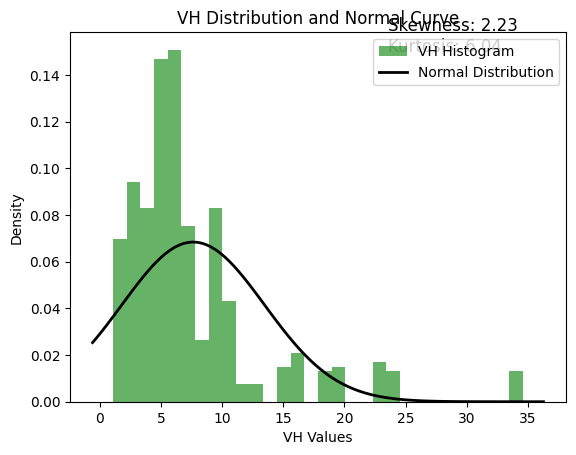

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, kurtosis

# Extract VH data from DataFrame
vh_data = df['TRI_100']

# Calculate skewness and kurtosis
vh_skew = skew(vh_data)
vh_kurtosis = kurtosis(vh_data)

# Create histogram
plt.hist(vh_data, bins=30, density=True, alpha=0.6, color='g', label='VH Histogram')

# Overlay with a normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(vh_data), np.std(vh_data))
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

# Annotate skewness and kurtosis values
plt.text(xmax*0.65, 0.15, f'Skewness: {vh_skew:.2f}\nKurtosis: {vh_kurtosis:.2f}', fontsize=12)

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('VH Values')
plt.ylabel('Density')
plt.title('VH Distribution and Normal Curve')

# Show plot
plt.show()


### ID duplicate removers


In [9]:
# filter any rows where snow Id has duplicates
column_name = 'ID_clean'
df = df_1000
df = df[(df['snow_depth'] < 200) & (df['snow_depth'] > 50)]
df[column_name].unique()

test = df.copy()
test[column_name] = pd.to_datetime(df[column_name])
test = df.sort_values(by=[column_name])

In [10]:
print('Main df', df.shape)
# make a list of Ids that have more than 1 measurement
ids = test[column_name].value_counts()
ids = ids[ids <= 1]
ids = ids.index.tolist()
# remove the rows that have more than one measurement
df_test = df[df[column_name].isin(ids)]
print('Filtered:', df_test.shape)
print(df_test[column_name].value_counts().to_markdown())

Main df (385, 26)
Filtered: (208, 26)
|   ID_clean |   count |
|-----------:|--------:|
|        289 |       1 |
|        143 |       1 |
|        404 |       1 |
|        386 |       1 |
|        385 |       1 |
|        242 |       1 |
|         98 |       1 |
|        241 |       1 |
|        243 |       1 |
|        244 |       1 |
|        100 |       1 |
|        101 |       1 |
|        122 |       1 |
|        266 |       1 |
|        409 |       1 |
|        123 |       1 |
|        267 |       1 |
|        274 |       1 |
|        419 |       1 |
|        276 |       1 |
|        278 |       1 |
|        417 |       1 |
|        275 |       1 |
|        277 |       1 |
|        130 |       1 |
|        262 |       1 |
|        116 |       1 |
|        117 |       1 |
|        114 |       1 |
|        397 |       1 |
|        111 |       1 |
|        113 |       1 |
|        112 |       1 |
|        257 |       1 |
|        110 |       1 |
|        398 |       1 |
|        401

### Visuals


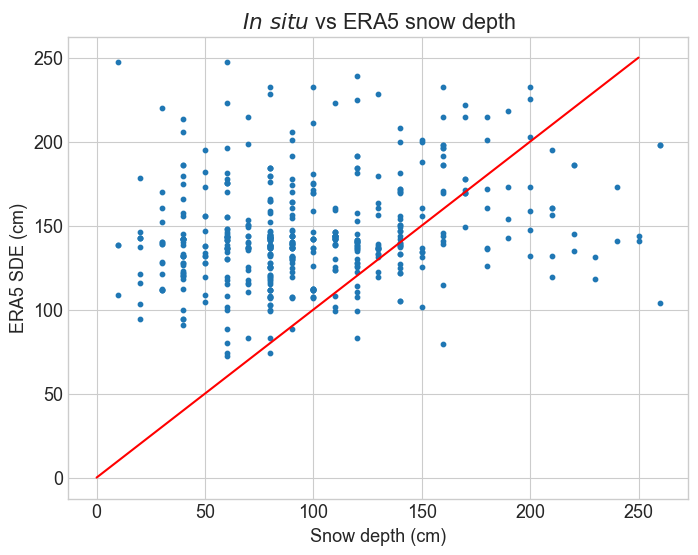

In [7]:
df_1000['era5_l_sde']
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({'font.size': 13})

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Define aspect ratio
aspect_ratio = 4/3

# Calculate figure size
width = 8
height = width / aspect_ratio

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(width, height))

# Add scatter plots
scatter = ax.scatter(df_1000['snow_depth'], df_1000['era5_l_sde'], s=10, label='VV')
ax.plot([0, 250], [0, 250], 'r-')
# Set labels and title
ax.set_xlabel('Snow depth (cm)')
ax.set_ylabel('ERA5 SDE (cm)')
ax.set_title(r'$\it{In\ situ}$ vs ERA5 snow depth')



plt.show()


In [49]:
import pandas as pd
import scipy.stats as stats


# Perform a normal distribution test (Shapiro-Wilk test)
shapiro_test = stats.shapiro(df_1000['snow_depth'])

print('Shapiro-Wilk Test Statistic:', shapiro_test.statistic)
print('Shapiro-Wilk Test p-value:', shapiro_test.pvalue)


Shapiro-Wilk Test Statistic: 0.9524786764758975
Shapiro-Wilk Test p-value: 2.2329113200970148e-11


In [59]:
# Spearman correlation
spearman_corr, spearman_p_value = stats.spearmanr(df_1000['VH/VV'], df_1000['snow_depth'])

print("Spearman correlation:", spearman_corr)
print("Spearman correlation p-value:", spearman_p_value)

Spearman correlation: 0.007863721777158373
Spearman correlation p-value: 0.8628587039241642


In [57]:
from scipy import stats

# Pearson correlation
pearson_corr, pearson_p_value = stats.pearsonr(df_1000['VH/VV'], df_1000['snow_depth'])

print("Pearson correlation:", pearson_corr)
print("Pearson correlation p-value:", pearson_p_value)


Pearson correlation: -0.01146314147307334
Pearson correlation p-value: 0.8011907398473307


In [54]:
from scipy import stats

# Kendall's Tau correlation
kendall_tau_corr, kendall_tau_p_value = stats.kendalltau(df_1000['VH/VV'], df_1000['snow_depth'])

print("Kendall's Tau correlation:", kendall_tau_corr)
print("Kendall's Tau correlation p-value:", kendall_tau_p_value)


Kendall's Tau correlation: 0.0042710732926871196
Kendall's Tau correlation p-value: 0.8918368865254188


In [60]:
import numpy as np
from scipy import stats

# Apply log transformation
df_1000['VH/VV_log'] = np.log(df_1000['VH/VV'])
df_1000['snow_depth_log'] = np.log(df_1000['snow_depth'])

# Pearson correlation on log-transformed data
pearson_corr_log, pearson_p_value_log = stats.pearsonr(df_1000['VH/VV_log'], df_1000['snow_depth_log'])

print("Pearson correlation (log-transformed):", pearson_corr_log)
print("Pearson correlation p-value (log-transformed):", pearson_p_value_log)


Pearson correlation (log-transformed): -0.009336021281404613
Pearson correlation p-value (log-transformed): 0.837510815488813


In [9]:
#dataframe prep
df = df_100
# df = df_500
# df = df_1000
df['VH_decibel'] = 10 * np.log10(df['VH'] )
df['VV_decibel'] = 10 * np.log10(df['VV'] )

#remove snow depth outliers
# df = df[(df['snow_depth'] < 300) & (df['snow_depth'] > 90)]

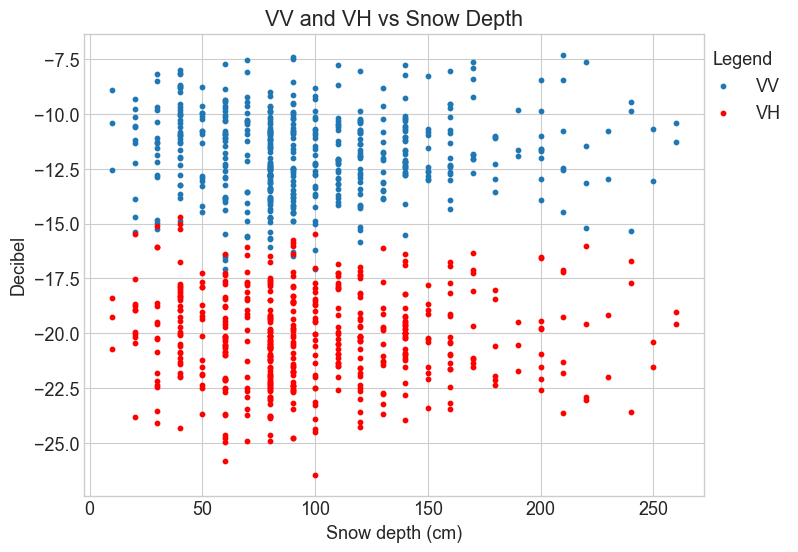

In [10]:
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({'font.size': 13})

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Define aspect ratio
aspect_ratio = 4/3

# Calculate figure size
width = 8
height = width / aspect_ratio

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(width, height))

# Add scatter plots
scatter = ax.scatter(df['snow_depth'], df['VV_decibel'], s=10, label='VV')
scatter2 = ax.scatter(df['snow_depth'], df['VH_decibel'], s=10, color='red', label='VH')

# Set labels and title
ax.set_xlabel('Snow depth (cm)')
ax.set_ylabel('Decibel')
ax.set_title('VV and VH vs Snow Depth')

# Customize legend
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
frame = legend.get_frame()
frame.set_facecolor('lightgray')  # Set background color
frame.set_edgecolor('black')      # Set edge color
frame.set_linewidth(1)            # Set border width
legend.set_title('Legend')  # Set legend title and font size

plt.show()


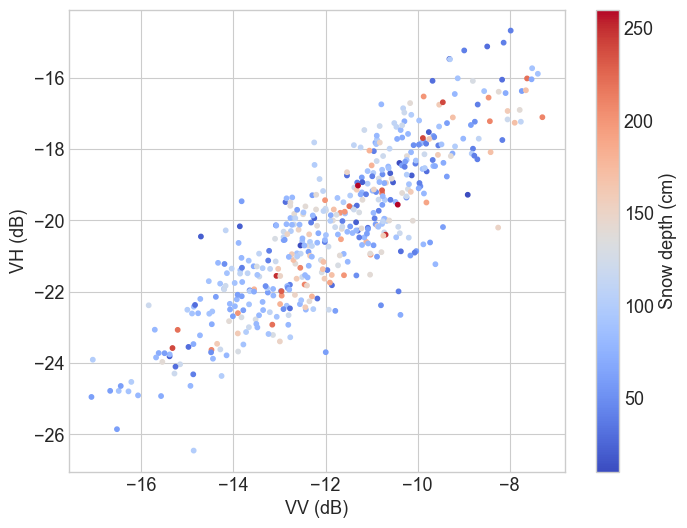

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
plt.style.use('seaborn-v0_8-whitegrid')
aspect_ratio = 4/3  # You can adjust this ratio as needed

# Calculate the figure size based on the aspect ratio and desired width
width = 8  # Desired width of the figure in inches
height = width / aspect_ratio


# Create a figure and axis objects using ax interface
fig, ax = plt.subplots(figsize=(width, height))  # Aspect ratio 4:3, width=8 inches, height=6 inches

# Add a line plot to the axis
scatter  = ax.scatter(df['VV_decibel'], df['VH_decibel'], c=df['snow_depth'], label='Original data', cmap='coolwarm', s = 10)

# Set x-axis and y-axis labels
ax.set_xlabel('VV (dB)')
ax.set_ylabel('VH (dB)')

# Set plot title
# ax.set_title('Example Plot')
# ax.legend()

# Add colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Snow depth (cm)')
# Display the plot
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 13})
# plt.style.use('seaborn-v0_8-whitegrid')
# aspect_ratio = 4/3  # You can adjust this ratio as needed

# # Calculate the figure size based on the aspect ratio and desired width
# width = 8  # Desired width of the figure in inches
# height = width / aspect_ratio


# # Create a figure and axis objects using ax interface
# fig, ax = plt.subplots(figsize=(width, height))  # Aspect ratio 4:3, width=8 inches, height=6 inches

# # Add a line plot to the axis
# scatter  = ax.scatter(df['snow_depth'], df['VH/VV'], label='Original data', s = 10)

# # Set x-axis and y-axis labels
# ax.set_xlabel('VV (dB)')
# ax.set_ylabel('VH (dB)')

# # Set plot title
# # ax.set_title('Example Plot')
# # ax.legend()

# # Add colorbar
# cbar = fig.colorbar(scatter)
# cbar.set_label('Snow depth (cm)')
# # Display the plot
# plt.show()


## Historgam

In [13]:
# prep data
#Load vindelfjallen data
csv_file_path_2023 = r"Data\Vindefjallen_data\Vindefjallen_cleaning\Vindefjallen_Granule_processing\vindefjallen_corner_coords_processing_2023_middletime.csv"

df_measurements = pd.read_csv(csv_file_path_2023) # Read the CSV file into a DataFrame
print(len(df_measurements))
df_measurements = df_measurements.dropna(subset=['MiddleTime'])
print(len(df_measurements))
df_measurements = df_measurements[~df_measurements["SnowDepth"].str.contains(r"\d+\+")]
df_measurements["SnowDepth"] = df_measurements["SnowDepth"].astype(np.int64)
df_measurements = df_measurements.reset_index(drop=True)
# print(df_measurements.to_markdown())
print(len(df_measurements))
# df = pd.DataFrame()
df_measurements['snow_depth'] = df_measurements['SnowDepth']



499
498
482


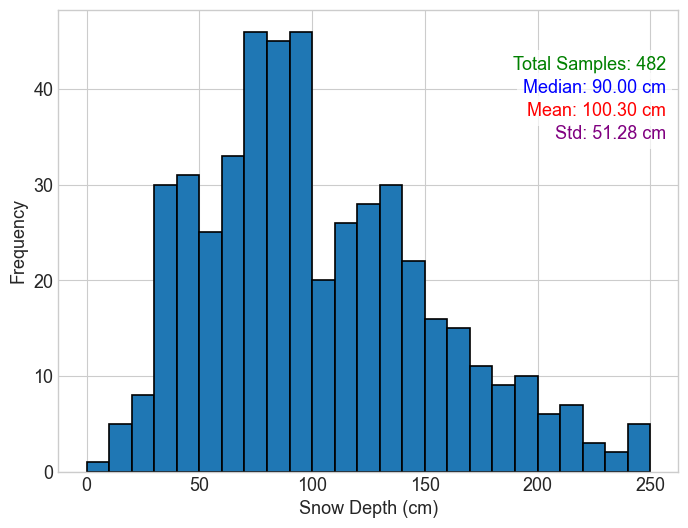

In [14]:
import matplotlib.pyplot as plt
import numpy as np

df = df_measurements

plt.rcParams.update({'font.size': 13})
plt.style.use('seaborn-v0_8-whitegrid')
aspect_ratio = 4/3  # You can adjust this ratio as needed

# Calculate the figure size based on the aspect ratio and desired width
width = 8  # Desired width of the figure in inches
height = width / aspect_ratio

# Create a figure and axis objects using ax interface
fig, ax = plt.subplots(figsize=(width, height))  # Aspect ratio 4:3, width=8 inches, height=6 inches

# Define bins with equal size
bin_size = 10
bins = np.arange(df['snow_depth'].min(), df['snow_depth'].max(), bin_size)

# Add a histogram to the axis
scatter = ax.hist(df['snow_depth'], bins=bins, edgecolor='black', linewidth=1.2)

# Set x-axis and y-axis labels
ax.set_xlabel('Snow Depth (cm)')
ax.set_ylabel('Frequency')

# Add total number of samples to the plot
total_samples = len(df['snow_depth'])
ax.text(0.98, 0.90, f'Total Samples: {total_samples}', verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes, color='green', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Calculate median, mean, and standard deviation of snow depth
median_snow_depth = df['snow_depth'].median()
mean_snow_depth = df['snow_depth'].mean()
std_snow_depth = df['snow_depth'].std()

# Add median, mean, and standard deviation annotations to the plot
ax.text(0.98, 0.85, f'Median: {median_snow_depth:.2f} cm', verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes, color='blue', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
ax.text(0.98, 0.80, f'Mean: {mean_snow_depth:.2f} cm', verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
ax.text(0.98, 0.75, f'Std: {std_snow_depth:.2f} cm', verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes, color='purple', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Display the plot
plt.show()


KeyError: 'VH'

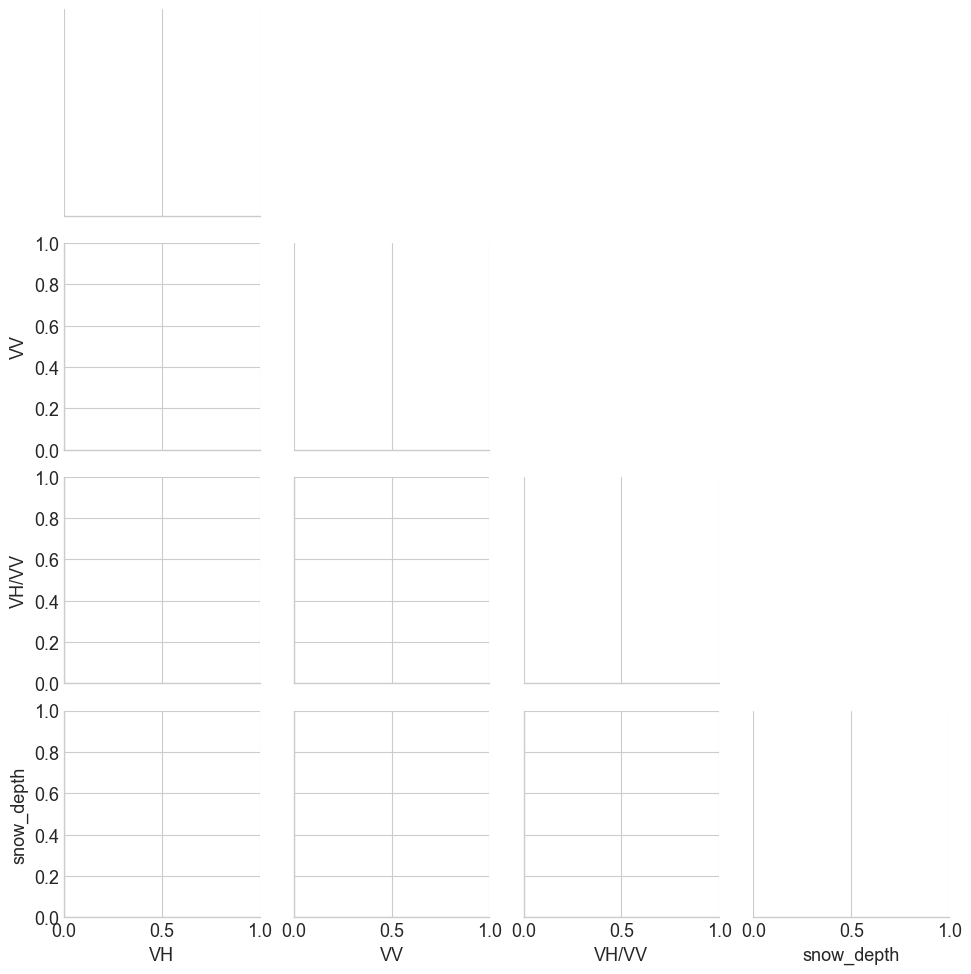

In [15]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
plt.style.use('seaborn-v0_8-whitegrid')
vars = [
        "VH",
        "VV",
        "VH/VV",
        # "era5_l_sde",
        'snow_depth']
df_final = df
g = sns.pairplot(
    df_final,
    diag_kind='hist',
    x_vars=vars,
    y_vars=vars,
      corner=True,
)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot, levels=4)
# g.map_diag(sns.kdeplot)
g.figure.suptitle(
    "Scatterplot and histogram of pairs of variables color coded by snow depth",
    fontsize=20,
    y=1.05,
)

In [18]:
df_new_names = df_100
# keep only the columns that are needed
df_new_names = df_new_names[[
    "snow_depth",
    "VH",
    "VV",
    "VH/VV",
    "angle",
    "time_difference_rnd",
    'orbitProp_ASCENDING',
    "ELEV_1000",
    "ASP_1000",
    "SLO_1000",
    "TPI_1000",
    "TRI_1000",
    "era5_l_skt",
    "era5_l_rsn",
    "era5_l_sde",
    "era5_l_sd",
    # "era5_l_lai_hv", "era5_l_lai_lv", "era5_l_tsn",
    
]]

# df_new_names = df_new_names.rename(columns={
#     "snow_depth": "Snow Depth",
#     "time_difference_rnd": "Time Diff.",
#     "orbitProp_ASCENDING": "Orbit dir.",
#     "era5_l_sde": "ERA5 SDE",
#     "angle": "Inc. angle",
#     "TPI_1000": "TPI",
#     "TRI_1000": "TRI",
#     "ASP_1000": "Aspect",
#     "SLO_1000": "Slope",
#     "ELEV_1000": "Elevation",
#     "era5_l_rsn": "ERA5 RSN",
#     "era5_l_skt": "ERA5 SKT",
#     "era5_l_sd": "ERA5 SD", 
    
# })

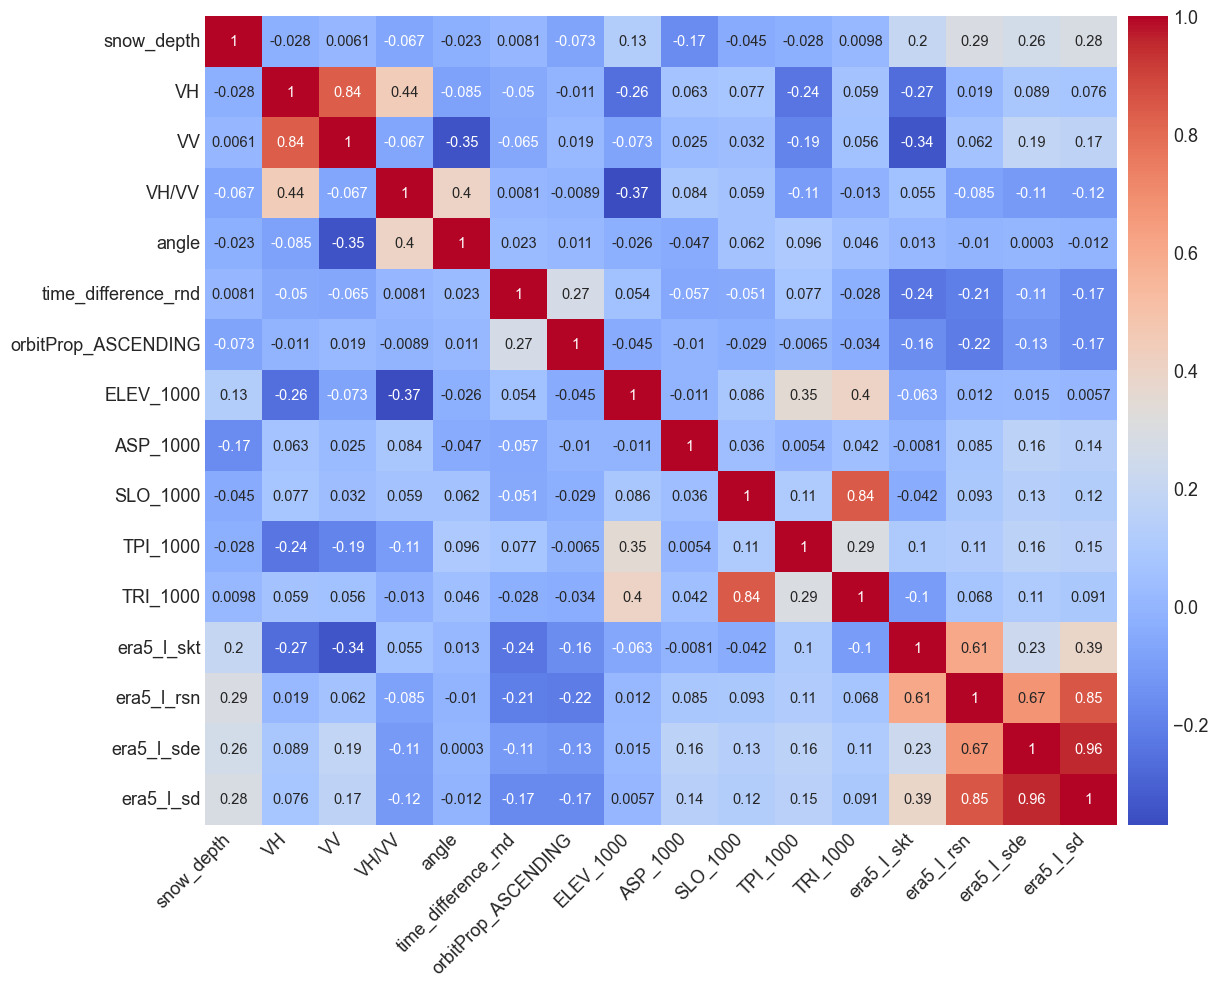

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 16})

# calculate correlation matrix
plt.style.use('seaborn-v0_8-whitegrid')
df_corr = df_new_names.copy()
corr = df_corr.corr()

aspect_ratio = 4/3  # You can adjust this ratio as needed

# Calculate the figure size based on the aspect ratio and desired width
width = 14  # Desired width of the figure in inches
height = width / aspect_ratio

# Create a figure and axis objects using ax interface
# fig, ax = plt.subplots(figsize=(width, height)) 

plt.figure(figsize=(width, height))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    # mask=mask,
    xticklabels=corr.columns, 
    yticklabels=corr.columns,
    annot=True,
    cmap='coolwarm',
    annot_kws={"size": 10.5},
    cbar_kws={ "pad": 0.01},  # Adjust 'pad' to move color bar closer

)
plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.title('Correlation Heatmap')
plt.grid(False)  # Remove the background grid
plt.show()


# Supervised learning


## Random forest

links:

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/ -- Definitive Guide to the Random Forest Algorithm with Python and Scikit-Learn


### Assesing weight of parameters


In [ ]:
# NEw stuff
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
# Number of features to consider at every split
feats_divded = round(len(X.columns)/3)
n_feats = round(len(X.columns))
max_features = ['sqrt',feats_divded, n_feats]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num=3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start=2, stop=4, num=3)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=3, num=3)]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    'max_features': max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    # 'bootstrap': bootstrap,
}
print(random_grid)

In [ ]:
#mini me

# NEw stuff
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
# max_features = ['sqrt',feats_divded, n_feats]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num=4)]
max_depth.append(None)

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    # 'max_features': max_features,
    "max_depth": max_depth
}
print(random_grid)

In [ ]:
# The original
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=5)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    'max_features': max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    #    'bootstrap': bootstrap,
    "max_features": [0.5, 1, "sqrt"],
}
print(random_grid)

### Whole dataset


In [ ]:
df_model = df_test #removed some duplicates
# df_model = df
X = df_model[[
    "VH",
    "VV",
    "VH/VV",
    "angle",
    "time_difference_rnd",
    "original",
    "EncodedTriangleCorner",
    # "temperature",
    'orbitProp_ASCENDING',
    'orbitProp_DESCENDING',
    'VEGTYP',

    # "ELEV_100",
    # "ASP_100",
    # "SLOP_100",
    # "TPI_100",
    # "TRI_100",

    # "TPI_500",
    # "TRI_500",
    # "ELEV_500",
    # "ASP_500",
    # "SLO_500",

    "TPI_1000",
    "TRI_1000",
    "ELEV_1000",
    "ASP_1000",
    "SLO_1000",

    "t2m",
    # "rsn",
    # "sd",
    "rsn",
]]
# y = df_model['snow_depth']
y = df_model["snow_depth_bins"]
# y = df_model["rsn"]
print(X.shape)
splitting_the_dataset = False

In [ ]:
# Grid search for best fit model hyperparameters
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    verbose=2,
    random_state=69,
    n_jobs=-1,
    cv=3,
)
rf_random.fit(X, y)
rf_random.best_params_

In [ ]:
params = {  # old
    "n_estimators": 500,
    "min_samples_split": 2,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": 10,
    "bootstrap": False,
}

# Initialize and train the Random Forest Regressor
rfr = RandomForestRegressor(**params, random_state=42, oob_score=False)
rfr.fit(X, y)

# Make predictions
y_pred = rfr.predict(X)

# Calculate metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y, y_pred)
reference_value = np.ptp(y)
relative_rmse = rmse / reference_value

# Print metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Relative Root Mean Square Error (Relative RMSE): {relative_rmse:.2f}")

# Try to print OOB score if available, otherwise print "No OOB"
try:
    print(f"OOB score: {rfr.oob_score_:.2f}")
except AttributeError:
    print("No OOB")

print(f"R2: {rfr.score(X, y):.3f}")

In [ ]:
importances = rfr.feature_importances_
# importances.sort()
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align="center")
plt.yticks(range(len(importances)), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Scores")
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
tree.plot_tree(
    rfr.estimators_[0], feature_names=X.columns, fontsize=8, filled=True, rounded=True
)

### Split set


In [5]:
# df_model = df_test
df_model = df
vars = [
    "VH",
    "VV",
    "VH/VV",
    "angle",
    "time_difference_rnd",
    'orbitProp_ASCENDING',
    
    # "ELEV_100",
    # "ASP_100",
    # "SLOP_100",
    # "TPI_100",
    # "TRI_100",
    
    # "t2m",
    # "rsn",
    
    # "rsd"
    
    # 'orbitProp_DESCENDING',
    # "sd",
    # "rsd",

    # "original",
    # "EncodedTriangleCorner",

    # 'VEGTYP',
    # "temperature",

    # "TPI_500",
    # "TRI_500",
    # "ELEV_500",
    # "ASP_500",
    # "SLO_500",

    # "TPI_1000",
    # "TRI_1000",
    # "ELEV_1000",
    # "ASP_1000",
    # "SLO_1000",
]
X = df_model[vars]
y = df_model['snow_depth']
# y = df_model["snow_depth_bins"]
# y = df_model["rsd"]
print(X.shape)
splitting_the_dataset = True

(482, 6)


In [ ]:
test_size = 0.2
random_state_split = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state_split,
    stratify=y
)
print(X_train.shape, X_test.shape)  # split dataset

In [ ]:
# Grid search for best fit model hyperparameters
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=2,
    random_state=42,
    verbose=3,
    n_jobs=-1,
    cv=KFold(n_splits=2, shuffle=True, random_state=1),
)
rf_random.fit(X_train, y_train)
params = rf_random.best_params_
random_params = rf_random.best_params_
rf_random.best_params_

In [ ]:
params ={'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 6,
 'max_depth': 40,
 'bootstrap': True}
random_state = 42
rfr = RandomForestRegressor(random_state=random_state, **params)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = rfr.score(X_test, y_test)
reference_value = np.ptp(y_test)
relative_rmse = rmse / reference_value
print(f"Mean Absolute Error (MAE): {mae:.1f} <-> y mean_pred {y.mean():.0f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {(mape*100):.2f}%")
print(f"Relative RMSE {relative_rmse:.2f}")
# print(f"OOB score: {rfr.oob_score_:.2f}")
print(f"max_error: {max_error(y_test, y_pred):.2f}")
print(f"R2: {r2:.2f}")
r2_score(y_test, y_pred).round(2)

In [ ]:
def statistical_stats(input_y):
    mean = np.mean(input_y)
    std = np.std(input_y)
    median = np.median(input_y)
    max_val = np.max(input_y)
    min_val = np.min(input_y)
    return mean, std, median, max_val, min_val

mean, std, median, max_val, min_val = statistical_stats(y_pred)
print(f"Mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}, max: {max_val:.2f}, min: {min_val:.2f}")
mean, std, median, max_val, min_val = statistical_stats(y)
print(f"Mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}, max: {max_val:.2f}, min: {min_val:.2f}")

# testing

https://inside-machinelearning.com/en/cross-validation-tutorial/ for info about CV

https://github.com/Lacerdash/Nested-Cross-Validation/blob/master/Churn%20Prediction.ipynb 

for Kfold code and nested loop

In [ ]:
test_size = 0.2
random_state_split = 42
X_train_test, X_gtest, y_train_test, y_gtest = train_test_split( 
    X, y,
    test_size=test_size,
    random_state=random_state_split,
    stratify=y
    )
# print(X_train.shape, X_test.shape)  # split dataset
print(X_train_test.shape, X_gtest.shape)  # split dataset

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train_test, y_train_test)

y_pred = rfr.predict(X_gtest)


#mae
print(rfr.score(X_gtest, y_gtest))
print(mean_absolute_error(y_gtest, y_pred))


In [ ]:
from sklearn.model_selection import cross_val_predict
random_state = 42
# inner_cv = KFold(n_splits = 2, shuffle=True, random_state=random_state)
outer_cv = KFold(n_splits = 10, shuffle=True, random_state=random_state)

rfr = RandomForestRegressor(random_state=random_state)


scores = cross_val_score(rfr, X, y, cv = outer_cv, scoring='neg_mean_absolute_error')
# cross_val_predict(hp_search, X, y, cv = outer_cv)
print(f'Mean Score: {-scores.mean()}')
print(f'Scores ---> {scores.round(3)}')

In [ ]:
outer_cv = KFold(n_splits = 10,shuffle=True, random_state=random_state)

rfr = RandomForestRegressor(random_state=random_state)
cv_results = cross_validate(rfr, X_train_test, y_train_test, cv=outer_cv, return_estimator=True)


print(cv_results['test_score'].mean())

gtest_score = []
gtest_mae = []
for i in range(len(cv_results['estimator'])):
  gtest_score.append(cv_results['estimator'][i].score(X_gtest, y_gtest))
  gtest_mae.append(mean_absolute_error(y_gtest, cv_results['estimator'][i].predict(X_gtest)))
  
sum(gtest_mae) / len(gtest_score)

In [ ]:
minst = np.argmin(gtest_mae)

print(mean_absolute_error(y_gtest, cv_results['estimator'][minst].predict(X_gtest)))
print(mean_squared_error(y_gtest, cv_results['estimator'][minst].predict(X_gtest)))
print(np.sqrt(mean_squared_error(y_gtest, cv_results['estimator'][minst].predict(X_gtest))))

# Test með nested loopð

In [7]:
test_size = 0.25
random_state_split = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state_split,
    stratify=y
)
#drop rsn from X_test and X_train
# X_train = X_train_1.drop(columns=['rsd'])
# X_test = X_test_1.drop(columns=['rsd'])
# X = X.drop(columns=['rsd'])
print(X_train.shape, X_test.shape)  # split dataset


(361, 6) (121, 6)


In [ ]:
from sklearn.model_selection import cross_val_predict
random_state = 42
inner_cv = KFold(n_splits = 5, shuffle=True, random_state=random_state)
outer_cv = KFold(n_splits = 5, shuffle=True, random_state=random_state)

hp_search = RandomizedSearchCV(RandomForestRegressor(), 
                               param_distributions=random_grid, 
                               n_iter= 100, 
                               cv = inner_cv,
                               random_state=42,
                               scoring='neg_mean_squared_error')

# scores = cross_val_score(hp_search, X_train, y_train, cv = outer_cv, scoring='neg_mean_absolute_error')
scores = cross_val_score(hp_search, X, y, cv = outer_cv, scoring='neg_mean_absolute_error')

print(f'Mean Score: {-scores.mean().round(0)}')
print(f'Scores ---> {scores.round(0)}')

In [ ]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
# params = {'n_estimators': 200, 'min_samples_split': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
params = {
    "max_depth": 40,
    "max_features": 2,
    "min_samples_leaf": 3,
    "min_samples_split": 3,
    "n_estimators": 100,
}
rfr = RandomForestRegressor(random_state=random_state, **params)
cv_results = cross_validate(rfr, X_train, y_train, cv=outer_cv, return_estimator=True)

In [ ]:
gtest_score = []
gtest_mae = []
for i in range(len(cv_results["estimator"])):
    gtest_score.append(cv_results["estimator"][i].score(X_test, y_test))
    gtest_mae.append(
        mean_absolute_error(y_test, cv_results["estimator"][i].predict(X_test))
    )

print(sum(gtest_score) / len(gtest_mae))
print(sum(gtest_mae) / len(gtest_mae))

In [ ]:
cv_results["estimator"][minst].fit(X_train, y_train)
y_pred = rfr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = rfr.score(X_test, y_test)
print(f"Mean Absolute Error (MAE): {mae:.1f} <-> y mean_pred {y.mean():.0f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2: {r2:.2f}")

In [ ]:
minst = np.argmin(gtest_mae)

In [ ]:
df_test = X_test_1.copy()
df_test['y_pred'] = y_pred
df_test['y_test'] = y_test



mean, std, median, max_val, min_val = statistical_stats(df_test['y_pred'])
print(f"Mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}, max: {max_val:.2f}, min: {min_val:.2f}")
mean, std, median, max_val, min_val = statistical_stats(df_test['rsd'])
print(f"Mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}, max: {max_val:.2f}, min: {min_val:.2f}")
mean, std, median, max_val, min_val = statistical_stats(y)
print(f"Mean: {mean:.2f}, std: {std:.2f}, median: {median:.2f}, max: {max_val:.2f}, min: {min_val:.2f}")

# End test

# anað test

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np

# `outer_cv` creates 3 folds for estimating generalization error
outer_cv = KFold(3)

# when we train on a certain fold, we use a second cross-validation
# split in order to choose hyperparameters
inner_cv = KFold(3)

# create some regression data
X, y = make_regression(n_samples=1000, n_features=10)

# give shorthand names to models and use those as dictionary keys mapping
# to models and parameter grids for that model
models_and_parameters = {
    'svr': (SVR(),
            {'C': [0.01, 0.05, 0.1, 1]}),
    'rf': (RandomForestRegressor(),
           {'max_depth': [5, 10, 50, 100, 200, 500]})}

# we will collect the average of the scores on the 3 outer folds in this dictionary
# with keys given by the names of the models in `models_and_parameters`
average_scores_across_outer_folds_for_each_model = dict()

# find the model with the best generalization error
for name, (model, params) in models_and_parameters.items():
    # this object is a regressor that also happens to choose
    # its hyperparameters automatically using `inner_cv`
    regressor_that_optimizes_its_hyperparams = GridSearchCV(
        estimator=model, param_grid=params,
        cv=inner_cv, scoring='neg_mean_squared_error')

    # estimate generalization error on the 3-fold splits of the data
    scores_across_outer_folds = cross_val_score(
        regressor_that_optimizes_its_hyperparams,
        X, y, cv=outer_cv, scoring='neg_mean_squared_error')

    # get the mean MSE across each of outer_cv's 3 folds
    average_scores_across_outer_folds_for_each_model[name] = np.mean(scores_across_outer_folds)
    error_summary = 'Model: {name}\nMSE in the 3 outer folds: {scores}.\nAverage error: {avg}'
    print(error_summary.format(
        name=name, scores=scores_across_outer_folds,
        avg=np.mean(scores_across_outer_folds)))
    print()

print('Average score across the outer folds: ',
      average_scores_across_outer_folds_for_each_model)

many_stars = '\n' + '*' * 100 + '\n'
print(many_stars + 'Now we choose the best model and refit on the whole dataset' + many_stars)

best_model_name, best_model_avg_score = max(
    average_scores_across_outer_folds_for_each_model.items(),
    key=(lambda name_averagescore: name_averagescore[1]))

# get the best model and its associated parameter grid
best_model, best_model_params = models_and_parameters[best_model_name]

# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(best_model, best_model_params, cv=inner_cv)
final_regressor.fit(X, y)

print('Best model: \n\t{}'.format(best_model), end='\n\n')
print('Estimation of its generalization error (negative mean squared error):\n\t{}'.format(
    best_model_avg_score), end='\n\n')
print('Best parameter choice for this model: \n\t{params}'
      '\n(according to cross-validation `{cv}` on the whole dataset).'.format(
      params=final_regressor.best_params_, cv=inner_cv))

# MAIN PROCESSING

In [6]:
#dataset prep
# df_model = df_test
df_model = df
vars = [
    "VH",
    "VV",
    "VH/VV",
    "angle",
    "time_difference_rnd",
    'orbitProp_ASCENDING',

    'rsd'
    
    # "ELEV_100",
    # "ASP_100",
    # "SLOP_100",
    # "TPI_100",
    # "TRI_100",
    
    # "t2m",
    # "rsn",
    # "sd",
    # 'orbitProp_DESCENDING',
    # 
    # "original",
    # "EncodedTriangleCorner",
]
X = df_model[vars]
y = df_model['snow_depth']
print(X.shape)

(482, 7)


In [7]:
test_size = 0.25
random_state_split = 42
X_train_1, X_test_1, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state_split,
    stratify=y
)
#drop rsn from X_test and X_train
X_train = X_train_1.drop(columns=['rsd'])
X_test = X_test_1.drop(columns=['rsd'])
X = X.drop(columns=['rsd'])
print(X_train.shape, X_test.shape)  # split dataset


(361, 6) (121, 6)


In [8]:
# define search space
n_estimators = [int(x) for x in np.linspace(start=100, stop=400, num=4)]
max_depth = [int(x) for x in np.linspace(10, 50, num=5)]
max_features = [0.3, 0.4, 0.5]
# https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d
# Create the  grid
grid = {
    # "n_estimators": n_estimators,
    # "max_depth": max_depth,
    'max_features': max_features,
}
grid

{'max_features': [0.3, 0.4, 0.5]}

In [9]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
# configure the cross-validation procedure
cv_inner = KFold(n_splits=2, shuffle=True, random_state=random_state)
cv_outer = KFold(n_splits=2, shuffle=True, random_state=random_state)
# define the model
model = RandomForestRegressor(random_state=random_state)
# define search
search = GridSearchCV(
    model, grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=cv_inner
)

# execute the nested cross-validation
scores = cross_validate(
    search,
    X_train,
    y_train,
    scoring=('r2', 
             'neg_mean_squared_error', 
             'neg_mean_absolute_error',
             'neg_root_mean_squared_error'),
    cv=cv_outer,
    n_jobs=-1,
    return_estimator=True,
)

In [45]:
#stats fyrir score
best_MAE = np.argmax(scores["test_neg_mean_absolute_error"])
best_r2 = np.argmin(scores["test_r2"])
bestMSE = np.argmax(scores['test_neg_root_mean_squared_error'])
bestRMSE = np.argmax(scores['test_neg_mean_squared_error'])
print(best_MAE, best_r2, bestMSE, bestRMSE)

print(-scores['test_r2'][best_r2])
print(-scores['test_r2'])
print(-scores['test_neg_mean_absolute_error'][best_MAE])
print(-scores['test_neg_mean_absolute_error'])
print(-scores['test_neg_root_mean_squared_error'][bestMSE])
print(-scores['test_neg_root_mean_squared_error'])
print(-scores['test_neg_mean_squared_error'][bestRMSE])
print(-scores['test_neg_mean_squared_error'])

1 1 1 1
0.2277220806644611
[0.03221837 0.22772208]
39.729444444444454
[40.25801105 39.72944444]
49.21924815444552
[54.24982267 49.21924815]
2422.5343888888888
[2943.04325967 2422.53438889]


In [46]:
# summarize the estimated performance of the model
mae_mean = mean(-scores['test_neg_mean_absolute_error'])
mae_std = std(scores['test_neg_mean_absolute_error'])
r2_mean = mean(-scores['test_r2'])
r2_std = std(scores['test_r2'])
mse_mean = mean(-scores['test_neg_mean_squared_error'])
mse_std = std(scores['test_neg_mean_squared_error'])
rmse_mean = mean(-scores['test_neg_root_mean_squared_error'])
rmse_std = std(scores['test_neg_root_mean_squared_error'])

print(f"MAE: {mae_mean:.3f} ({mae_std:.3f})")
print(f"R2: {r2_mean:.3f} ({r2_std:.3f})")
print(f"mean_squared_error: {mse_mean:.3f} ({mse_std:.3f})")
print(f"mean_squared_error: {rmse_mean:.3f} ({rmse_std:.3f})")

MAE: 39.994 (0.264)
R2: 0.130 (0.098)
mean_squared_error: 2682.789 (260.254)
mean_squared_error: 51.735 (2.515)


In [48]:
#summary fyrir test
rfr_fit = scores['estimator']
best_rfr = rfr_fit[bestRMSE].best_estimator_
best_rfr.fit(X_train, y_train)
y_pred = best_rfr.predict(X_test)
print(mean_absolute_error(y_test, y_pred),"mae")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = best_rfr.score(X_test, y_test)

print(f"Mean Absolute Error (MAE): {mae:.1f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2: {r2:.2f}")

37.34214876033058 mae
Mean Absolute Error (MAE): 37.3
Mean Squared Error (MSE): 2281.67
Root Mean Squared Error (RMSE): 47.77
R2: -0.03


In [ ]:
#test á öllum folds
best_rfr = rfr_fit[bestRMSE].best_estimator_
# best_rfr = scores['estimator'][1]
best_rfr.fit(X_train, y_train)
y_pred = best_rfr.predict(X_test)
print(mean_absolute_error(y_test, y_pred),"mae")
for i in range(len(rfr_fit)):
    rfr_fit[i].best_estimator_.fit(X_train, y_train)
    y_pred = rfr_fit[i].best_estimator_.predict(X_test)
    print(i)
    print(mean_absolute_error(y_test, y_pred))
    print(r2_score(y_test, y_pred))

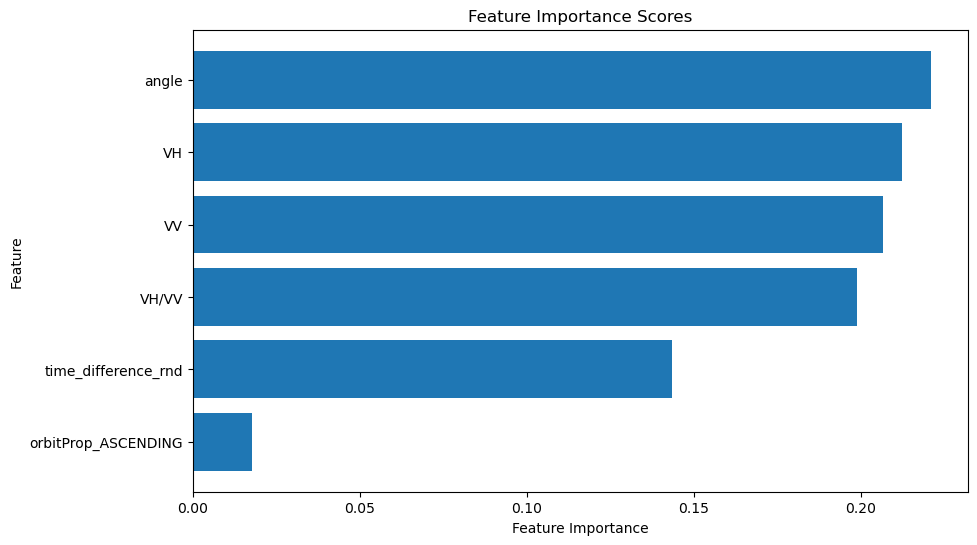

In [109]:
f_i = list(zip(X.columns, best_rfr.feature_importances_))
f_i.sort(key=lambda x: x[1])
plt.figure(figsize=(10, 6))

plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Scores")
plt.show()

In [10]:
#new log

current_datetime = datetime.datetime.now()  # Get the current date and time
# Format the current date and time as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

def mean_error(y_test, y_pred):
    return (y_pred - y_test).sum() / len(y_pred)


#model evaluation
mae_mean = mean(-scores['test_neg_mean_absolute_error'])
mae_std = std(scores['test_neg_mean_absolute_error'])
mse_mean = mean(-scores['test_neg_mean_squared_error'])
mse_std = std(scores['test_neg_mean_squared_error'])
rmse_mean = mean(-scores['test_neg_root_mean_squared_error'])
rmse_std = std(scores['test_neg_root_mean_squared_error'])
r2_mean = mean(-scores['test_r2'])
r2_std = std(scores['test_r2'])

#best model setup
bestRMSE = np.argmax(scores['test_neg_mean_squared_error'])
rfr_fit = scores['estimator']

best_rfr = rfr_fit[bestRMSE].best_estimator_
best_rfr.fit(X_train, y_train)
y_pred = best_rfr.predict(X_test)

best_best_params = rfr_fit[bestRMSE].best_params_

#test data evaluatin/best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = best_rfr.score(X_test, y_test)
me = mean_error(y_test, y_pred)

#feature imporance
columns = list(X.columns)
feature_imp = list(best_rfr.feature_importances_)

# Athugasemdir
comment = "Best 1000m SAR"

#long lists
listi_y_pred = list(y_pred)
listi_era5_rsd = list(X_test_1['rsd'])
listi_y_test = list(y_test)


In [11]:
#pickle that bad boy
results = {}

results['blabla'] = {
    "formatted_datetime": formatted_datetime,
    "mae_mean": mae_mean,
    "mae_std": mae_std,
    "mse_mean": mse_mean,
    "mse_std": mse_std,
    "rmse_mean": rmse_mean,
    "rmse_std": rmse_std,
    "r2_mean": r2_mean,
    "r2_std": r2_std,
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "r2": r2,
    "me": me,
    "columns": columns,
    "feature_imp": feature_imp,
    "best_params": best_best_params,
    "comment": comment,
    "y_prediction": listi_y_pred,
    "y_test": listi_y_test,
    "rsd_at_y_pred": listi_era5_rsd
}
results['asddasasd'] = {
    "formatted_datetime": formatted_datetime,
    "mae_mean": mae_mean,
    "mae_std": mae_std,
    "mse_mean": mse_mean,
    "mse_std": mse_std,
    "rmse_mean": rmse_mean,
    "rmse_std": rmse_std,
    "r2_mean": r2_mean,
    "r2_std": r2_std,
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "r2": r2,
    "me": me,
    "columns": columns,
    "feature_imp": feature_imp,
    "best_params": best_best_params,
    "comment": comment,
    "y_prediction": listi_y_pred,
    "y_test": listi_y_test,
    "rsd_at_y_pred": listi_era5_rsd
}

# import os
# import pickle

# name_model = "1000m_SAR.pkl" 
# pickleName = r"Scripts\Python\data_analysis\results_pickle"
# path_to_pickle  = os.path.join(pickleName, name_model)
# try:
#     # Store the results dictionary in a pickle file
#     with open(path_to_pickle, 'xb') as handle:
#         pickle.dump(results, handle)

#     print('New pickle created')
# except FileExistsError:
#     print('FileExistsError')

In [12]:
results

{'blabla': {'formatted_datetime': '2024-05-14 11:38:45',
  'mae_mean': 39.99372774708411,
  'mae_std': 0.26428330263965094,
  'mse_mean': 2682.7888242786985,
  'mse_std': 260.2544353898097,
  'rmse_mean': 51.73453541195577,
  'rmse_std': 2.515287257510245,
  'r2_mean': 0.1299702232573886,
  'r2_std': 0.09775185740707248,
  'mae': 37.34214876033058,
  'mse': 2281.672396694215,
  'rmse': 47.766854582379764,
  'r2': -0.03324236526946134,
  'me': 2.7338842975206608,
  'columns': ['VH',
   'VV',
   'VH/VV',
   'angle',
   'time_difference_rnd',
   'orbitProp_ASCENDING'],
  'feature_imp': [0.19769471971205516,
   0.19370295121504272,
   0.21882717961566164,
   0.23671795956351968,
   0.12868648776124955,
   0.024370702132471445],
  'best_params': {'max_features': 0.5},
  'comment': 'Best 1000m SAR',
  'y_prediction': [107.0,
   116.7,
   121.5,
   98.2,
   73.9,
   88.0,
   100.1,
   101.6,
   110.1,
   105.7,
   97.1,
   110.7,
   104.9,
   98.3,
   109.6,
   113.4,
   100.8,
   72.2,
   10

In [31]:
loaded_model = pickle.load(open(path_to_pickle, 'rb'))


In [62]:
import pandas as pd

# Your dictionary
data = {
    'A': [1, 2, 3],
    'B': ['a', 'b', 'c'],
    'C': [[4, 5], [6, 7], [8, 9]],
    'D': [10, 10, 10]  # Repeat scalar value for each row
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

print(df)


   A  B       C   D
0  1  a  [4, 5]  10
1  2  b  [6, 7]  10
2  3  c  [8, 9]  10


### Pickle

In [ ]:
type(y_pred)
#export y_pred to pickle
# pickleName = r"Scripts\Python\data_analysis\y_pred_pickle\y_pred_1000_SAR_Terrain.pkl"
with open(pickleName, 'wb') as f:
    pickle.dump(y_pred, f)
    
# Load the model from disk
loaded_model = pickle.load(open(pickleName, 'rb'))
# loaded_model

#reload
loaded_model = pickle.load(open(pickleName, 'rb'))


In [ ]:
f_i = list(zip(X.columns, rfr.feature_importances_))
f_i.sort(key=lambda x: x[1])
plt.figure(figsize=(10, 6))

plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Scores")
plt.show()


In [ ]:
plt.figure(figsize=(26, 20))
tree.plot_tree(
    rfr.estimators_[1], feature_names=X.columns, fontsize=8, filled=True, rounded=True
)
plt.show()

In [ ]:
#testing new stuff
#Looper for random state
listi_mae = []
listi_r2 = []
# Initialize and train the Random Forest Regressor
print('id,  mae,  r2')

# test_size = 0.25
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=test_size,
#     random_state=260,
#     stratify=y
# )

for i in range(0,1001):
    #splitting the dataset
    
    test_size = 0.25
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=i,
        stratify=y
    )

    
    rfr = RandomForestRegressor(**params, oob_score=False, random_state=206)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = rfr.score(X_test, y_test)
    listi_mae.append(mae)
    listi_r2.append(r2)
    
# Calculate mean, standard deviation, and maximum values
mean_mae, mean_r2 = np.mean(listi_mae), np.mean(listi_r2)
min_mae, max_r2 = np.min(listi_mae), np.max(listi_r2)
# Get the index of the maximum and minimum values
min_mae_index, max_r2_index = np.argmin(listi_mae), np.argmax(listi_r2)

# Print all the statistics
print('Mean MAE:', mean_mae)
print('Mean R2:', mean_r2)

print('Max R2:', max_r2, ' index', max_r2_index)
print('Min MAE:', min_mae, ' index', min_mae_index)

# Calculate mean, standard deviation, and maximum values
mean_mae, mean_r2 = np.mean(listi_mae), np.mean(listi_r2)
min_mae, max_r2 = np.min(listi_mae), np.max(listi_r2)
# Get the index of the maximum and minimum values
min_mae_index, max_r2_index = np.argmin(listi_mae), np.argmax(listi_r2)

# Print all the statistics
print('Mean MAE:', mean_mae)
print('Mean R2:', mean_r2)

print('Max R2:', max_r2, ' index', max_r2_index)
print('Min MAE:', min_mae, ' index', min_mae_index)


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, s=20)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals against predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


### Logging

Activate cell when I have some interesting values to record and safekeep


In [16]:
current_datetime = datetime.datetime.now()  # Get the current date and time
# Format the current date and time as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
importances = rfr.feature_importances_
try:
    oob = round(rfr.oob_score_, 2)
except:
    oob = 'No OOB'

if splitting_the_dataset == True:
    split_text = f"\nSplit into -> test: {X_test.shape} and size: {X_train.shape}. Ratio: {test_size}"
elif splitting_the_dataset == False:
    split_text = f"\nNo split"

# Athugasemdir
comment = ""

# Open the text file in append mode
with open(r"Scripts\Python\data_analysis\data_log_new.txt", "a") as file:
    # Write the formatted datetime at the beginning
    file.write(f"\n\n\n---->{formatted_datetime}<-----\n")

    # Write each variable name, type, and value
    file.write(
        f'Comment: {comment}'
        f'\nCSV file1: {path_old}'
        f'\nCSV file2: {path_era5}'
        f'\nMain dataset (rows,columns): {df.shape}'
        f'\nCleaning parameters: T = {temperature}, std = {std}'
        f'\nCleaned dataset: {df.shape}'
    )

    file.write(
        f"\nModel dataset shape: {X.shape}"
        f"{split_text}"
        f"\nX Columns: {X.columns}"
        f"\nY model name: {y.name}"
        f"\nRandom state: {random_state}, split: {random_state_split}"
        f"\n\nMean Absolute Error: {mae:.2f}"
        f"\nMean Squared Error: {mse:.2f}"
        f"\nRoot Mean Squared Error: {rmse:.2f}"
        f"\nRelative RMSE: {relative_rmse:.2f}"
        f"\nMAPE: {mape:.2f}"
        f"\nOOB score: {oob}"
        f"\nmax_error: {max_error(y_test, y_pred):.2f}"
        f"\nR2: {r2:.2f}"
        f"\n\nBest params: {params}"
        f"\nAll params: {rfr.get_params()}"
        f"\nFeature importance:\n")

    for i, j in zip(X.columns, rfr.feature_importances_):
        file.write(f" - {i}: {j*100:.2f}%")

NameError: name 'rfr' is not defined

# plotting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data for demonstration
np.random.seed(0)  # for reproducibility
data = y_pred

# Create a box plot
plt.boxplot(data)

# Add title and labels
plt.title('Box Plot of Random Data')
plt.xlabel('Data')
plt.ylabel('Values')

# Show the plot
plt.show()
loaded_model.mean()

In [ ]:
# Log the random hyperparameter search results
def save_list_to_file(filename, list_data):
    with open(filename, 'wb') as f:
        pickle.dump(list_data, f)


def load_list_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# Filename of the Pickle file
filename = 'Scripts/Python/data_analysis/best_params.pkl'

# Check if the file exists
if os.path.exists(filename):
    # Load existing list of dictionaries from file
    dict_list = load_list_from_file(filename)
else:
    # If file doesn't exist, create an empty list
    dict_list = []

# Generate new dictionary (replace this with your method of generating dictionaries)
new_dict = rf_random.best_params_

# Check if the new dictionary already exists in the list
if new_dict not in dict_list:
    # Add the new dictionary to the existing list
    dict_list.append(new_dict)
    # Save the updated list back to the file
    save_list_to_file(filename, dict_list)
    print("New dictionary added successfully!")
else:
    print("Duplicate dictionary found. Not added.")

# Access individual dictionaries
print("All dictionaries:")
for index, dictionary in enumerate(dict_list, start=1):
    print(f"Index {index}: {dictionary}")

In [ ]:
# Access individual dictionaries and their values

def load_list_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


# Filename of the Pickle file
filename = 'Scripts/Python/data_analysis/best_params.pkl'

# Load the list of dictionaries from the Pickle file
loaded_list = load_list_from_file(filename)

# Create a dictionary to store the dictionaries with their indices
indexed_dict = {}

# Populate the indexed dictionary
for index, dictionary in enumerate(loaded_list, start=1):
    indexed_dict[index] = dictionary

# Access individual dictionaries in the indexed dictionary
print("Accessing individual dictionaries:")
for index, dictionary in indexed_dict.items():
    print(f"Index {index}: {dictionary}")

### Evaluate


In [ ]:
def evaluate_accuracy(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy


base_model = RandomForestRegressor(random_state=69)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_accuracy(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate_accuracy(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format(
    100 * (random_accuracy - base_accuracy) / base_accuracy))

## DEM Test


In [ ]:
# test

df_temp = df_DEM
X = df_temp[
    [
        # "temperatur",
        "TPI_100",
        "TPI_500",
        "TPI_1000",
        "TRI_100",
        "TRI_500",
        "TRI_1000",
        "ASP_100",
        "SLOP_100",
        "ASP_500",
        "SLO_500",
        "ASP_1000",
        "SLO_1000",
        "ELEV_100",
        "ELEV_500",
        "ELEV_1000",
    ]
]
y = df_temp["SnowDepth"]
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=69,
    n_jobs=-1,
)
rf_random.fit(X, y)
rf_random.best_params_

In [ ]:
# whole dataset
params = rf_random.best_params_
rfr = RandomForestRegressor(**params, random_state=69)
rfr.fit(X, y)
y_pred = rfr.predict(X)
print(rfr.score(X, y))

print("Mean Absolute Error:", mean_absolute_error(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, y_pred)))
print("R2: ", rfr.score(X, y))

In [ ]:
importances = rfr.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align="center")
plt.yticks(range(len(importances)), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Scores")
plt.show()

# features = X.columns
# # Obtain just the first tree
# first_tree = rfr.estimators_[0]

# plt.figure(figsize=(15,15))
# tree.plot_tree(first_tree,
#                feature_names=features,
#                fontsize=8,
#                filled=True,
#                rounded=True);

## Support vector machine


In [ ]:
# Import the Libraries and read the data into a Pandas DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Split the dataset into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)

In [ ]:
# Importing necessary libraries
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


import numpy as np

X = df_temp[
    [
        "VH",
        "VV",
        "VH/VV",
        "angle",
        # "orbitProp",
        "time_difference_rnd",
        "temperature",
        "orbitProp_ASCENDING",
        "orbitProp_DESCENDING",
    ]
]
# y = df['snow_depth']
y = df_temp["snow_depth"]

X_norm = normalize(X)
y_normalized = y
# normalize(y.values.reshape(1, -1), axis=1).ravel()  # Normalizing y directly without reshaping


# Creating and training the SVR model
svr_model = SVR()  # RBF kernel is commonly used for SVR
svr_model.fit(X_norm, y_normalized)

# Making predictions on the testing set
y_pred = svr_model.predict(X_norm)

# Calculating Mean Squared Error
mse = mean_squared_error(y_normalized, y_pred)

rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Visualization


In [ ]:
# plot vv and vh ratio
# fit a trend line
plt.figure(figsize=(8, 4))
sns.scatterplot(x="snow_depth", y="VV", data=df,
                hue="snow_depth", palette="viridis")
plt.title("VH")
plt.xlabel("VH")
plt.ylabel("VV")
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(x="snow_depth", y="VH", data=df,
                hue="snow_depth", palette="viridis")
plt.title("Scatter plot of VV and VH")
plt.xlabel("VV")
plt.ylabel("VV")
plt.show()

# Unsupervised learning


### K-means clustering

https://www.datacamp.com/tutorial/k-means-clustering-python

https://realpython.com/k-means-clustering-python/ -> current fav


In [ ]:
# Extracting the features from the DataFrame
features = df[
    [
        "VH",
        "VV",
        "VH/VV",
        "angle",
        # "orbitProp",
        "time_difference_rnd",
        "temperature",
        "orbitProp_ASCENDING",
        "orbitProp_DESCENDING",
        "snow_depth",
    ]
]

In [ ]:
# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features


# X_norm = normalize(X)
# y_normalized = normalize(y.values.reshape(1, -1), axis=1).ravel()  # Normalizing y directly without reshaping

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 69,
}

kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(scaled_features)

In [ ]:
print(kmeans.inertia_, kmeans.cluster_centers_, kmeans.n_iter_)
print(kmeans.labels_)

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 69,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeansSSE = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeansSSE.fit(scaled_features)
    sse.append(kmeansSSE.inertia_)

In [ ]:
from kneed import KneeLocator


kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
sns.scatterplot(data=features, x="snow_depth", y="VH/VV", hue=kmeans.labels_)

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### Clustering visuals


In [ ]:
df_final = features
df_final.loc[:, "cluster"] = kmeans.labels_
columns = [
    "VH",
    "VV",
    "VH/VV",
    "angle",
    "time_difference_rnd",
    "temperature",
    # "orbitProp_ASCENDING",
    # "orbitProp_DESCENDING",
    "snow_depth",
]
custom_palette = {"red": "red", "blue": "blue"}

g = sns.pairplot(
    df_final,
    hue="cluster",
    palette=["red", "blue"],
    #  diag_kind="kde",
    diag_kind="hist",
    x_vars=columns,
    y_vars=columns,
    #   corner=True,
)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot, levels=4, color=".2")
# g.map_diag(sns.kdeplot)
g.figure.suptitle(
    "Scatterplot and histogram of pairs of variables color coded by snow depth",
    fontsize=14,
    y=1.05,
)

### K-means clustering

From ChatGPT


In [ ]:
# Specifying the number of clusters
num_clusters = 2  # You can adjust this number as per your requirement

# Initializing the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fitting the model to the data
kmeans.fit(X)
# Adding the cluster labels to the DataFrame
df["cluster"] = kmeans.labels_

# Printing the cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Printing the counts of data points in each cluster
print("\nCounts of Data Points in Each Cluster:")
print(df["cluster"].value_counts())

### Cross-validation of model


In [ ]:
# leave one out
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt

cv = LeaveOneOut()

# build multiple linear regression model
model = RandomForestRegressor()

# use LOOCV to evaluate model
scores = cross_val_score(
    model, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1
)

print("Mean Squared Error:", mean(absolute(scores)))
print("Root Mean Squared Error:", np.sqrt(mean(absolute(scores))))